# Phase 1: Classification (assign Utility, Application, or Entity Tag)

In [2]:
version = "v_imen" # All options: v_imen, v_team
system = "pos" # All options: jforum, cargotracker, petclinic, pos
model_type = "albert" # All options: ft_codebert, word2vec, albert, codebert, roberta, bert

## 1.1 Create Embeddings

In [3]:
from transformers import AutoTokenizer, AutoModel, AlbertTokenizer, AlbertModel, RobertaModel, RobertaTokenizer, BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from utils import load_class_code_from_directory, load_data_from_csv, write_embeddings_to_csv, associate_classes_to_types
from embeddings import generate_embeddings_for_java_code, generate_word_embeddings_for_java_code
import nltk
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api

In [4]:
# Check if CUDA (GPU) is available and if so, set the device to GPU
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev)

In [5]:
# Select the model and tokenizer
if (model_type == "codebert"):
    tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base",force_download=False)
    model = AutoModel.from_pretrained("microsoft/codebert-base",force_download=False)
elif (model_type == "ft_codebert"):
    tokenizer = AutoTokenizer.from_pretrained("./codebert_finetuned",force_download=False)
    model = AutoModel.from_pretrained("./codebert_finetuned",force_download=False)
elif (model_type == "bert"):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") 
    model = BertModel.from_pretrained("bert-base-uncased") 
elif (model_type == "roberta"):
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    model = RobertaModel.from_pretrained("roberta-base")
elif (model_type == "albert"): 
    # pip3 install sentencepiece
    tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
    model = AlbertModel.from_pretrained("albert-base-v2")
elif model_type == "word2vec":
    # Download required NLTK datasets and initialize the lemmatizer
    nltk.download('wordnet')
    word_lemmatizer = WordNetLemmatizer()

    # Load Word2Vec model
    word2vec_model = api.load('word2vec-google-news-300')
else:
    raise NameError("model type not supported")

# Move the model to the GPU if available
model = model.to(device)

In [6]:
# Labels are 0: Application, 1: Utility, 2: Entity
class_labels = associate_classes_to_types(version, system)
print(class_labels)

{'com.rafsan.inventory.MainApp': 0, 'com.rafsan.inventory.controller.admin.AdminController': 0, 'com.rafsan.inventory.interfaces.CategoryInterface': 0, 'com.rafsan.inventory.controller.category.AddController': 0, 'com.rafsan.inventory.controller.category.CategoryController': 0, 'com.rafsan.inventory.controller.category.EditController': 0, 'com.rafsan.inventory.interfaces.EmployeeInterface': 0, 'com.rafsan.inventory.controller.employee.AddController': 0, 'com.rafsan.inventory.controller.employee.EditController': 0, 'com.rafsan.inventory.controller.employee.EmployeeController': 0, 'com.rafsan.inventory.interfaces.ProductInterface': 0, 'com.rafsan.inventory.controller.product.AddController': 0, 'com.rafsan.inventory.controller.product.EditController': 0, 'com.rafsan.inventory.controller.product.ProductController': 0, 'com.rafsan.inventory.interfaces.PurchaseInterface': 0, 'com.rafsan.inventory.controller.purchase.AddController': 0, 'com.rafsan.inventory.controller.purchase.PurchaseControl

In [7]:
# For each class in class_code, generate embeddings and add to class_embeddings dictionary
class_embeddings = {}
class_code = load_class_code_from_directory(system)
if model_type == "word2vec":
    class_embeddings = {class_name: generate_word_embeddings_for_java_code(code, model, word_lemmatizer) for class_name, code in class_code.items()}
else:
    class_embeddings = {class_name: generate_embeddings_for_java_code(code, model, tokenizer, device) for class_name, code in class_code.items()}

# Write embeddings to csv file
write_embeddings_to_csv(version, system, model_type, class_embeddings, class_labels)

## 1.2 Train classifiers

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

In [9]:
# Load data
filename = f"./generated_data/embedding/{version}_{system}_{model_type}_embeddings.csv"
class_names, labels, embeddings = load_data_from_csv(filename)

# Train-test split
Xtrain, Xtest, names_train, names_test = train_test_split(embeddings, class_names, test_size=0.3, random_state=0)

# Get labels for the training and test sets
ytrain, ytest = [[labels[class_names.index(name)] for name in lst] for lst in [names_train, names_test]]

# Ensure at least one instance of each class in the training data
unique_classes = set(labels)
for cls in unique_classes:
    if cls not in ytrain:
        cls_index = labels.index(cls)
        Xtrain = np.vstack([Xtrain, [embeddings[cls_index]]])
        ytrain.append(cls)

# Calculate class frequencies and mean frequency
class_freq = Counter(ytrain)
mean_count = sum(class_freq.values()) // len(class_freq)

# Identify classes that need resampling (e.g., significantly fewer than mean_count)
threshold = 0.7  # 70% of the mean_count
classes_to_resample = {cls: int(mean_count) for cls, count in class_freq.items() if count < mean_count * threshold}

# Check if all classes_to_resample have enough samples
skip_resampling = False
for class_label in classes_to_resample.keys():
    if class_label in class_freq and class_freq[class_label] < 2:  # k_neighbors + 1
        skip_resampling = True
        print(f"Skipping resampling for class {class_label} due to insufficient samples.")
        break

# Apply SMOTE
if not skip_resampling and classes_to_resample:
    sm = SMOTE(sampling_strategy=classes_to_resample, k_neighbors=1, random_state=42)
    Xtrain, ytrain = sm.fit_resample(Xtrain, ytrain)

# Calculate total type repartition

# Print information
print(f'Number of classes: {len(class_names)}\nResampled dataset shape: {Counter(ytrain)}')
print(f'len(Xtrain): {len(Xtrain)}\nlen(Xtest): {len(Xtest)}')
print(f'ytrain: {ytrain}\nytest: {ytest}')
print(f'ytrain count: {np.bincount(ytrain)}\nytest count: {np.bincount(ytest)}')
print(f'total class types repartition : {np.bincount(ytrain) + np.bincount(ytest)}')


Skipping resampling for class 1 due to insufficient samples.
Number of classes: 55
Resampled dataset shape: Counter({0: 21, 2: 16, 1: 1})
len(Xtrain): 38
len(Xtest): 17
ytrain: [0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0]
ytest: [2, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2, 0]
ytrain count: [21  1 16]
ytest count: [8 2 7]
total class types repartition : [29  3 23]


In [10]:
# # OPTIONAL: Please keep this code commented out unless you want to use it
# # This code ensures that each class is represented in the test set, proportional to its representation in the training set
# # Calculate class frequencies for training and test sets
# train_class_freq = Counter(ytrain)
# test_class_freq = Counter(ytest)

# # Calculate the ratio between the size of the training and test sets
# ratio = len(ytrain) / len(ytest)

# # Iterate over each class to make sure it has proportional representation in the test set
# for cls, train_count in train_class_freq.items():
#     expected_test_count = int(train_count / ratio)
#     actual_test_count = test_class_freq.get(cls, 0)

#     if actual_test_count < expected_test_count:
#         # Find instances in the training set to move to the test set
#         for _ in range(expected_test_count - actual_test_count):
#             cls_index = ytrain.index(cls)
#             Xtest = np.vstack([Xtest, [Xtrain[cls_index]]])
#             ytest.append(cls)
#             Xtrain = np.delete(Xtrain, cls_index, axis=0)
#             ytrain.pop(cls_index)

## Génération des rapports de classification (version textuelle)

In [11]:
def generate_classification_report(y_true, y_pred):
    # Identify unique labels in both true labels and predictions
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))

    # Map unique labels to their corresponding names
    label_names_map = {-1: "None", 0: "Application", 1: "Utility", 2: "Entity"}
    dynamic_label_names = [label_names_map[label] for label in unique_labels]

    # Generate and print the classification report
    print(classification_report(y_true, y_pred, target_names=dynamic_label_names))

## Génération des fichiers CSV pour la classification de chaque modèle et modèle de prédiction

In [12]:
import os
import pandas as pd

In [13]:
def generate_classification_report_to_csv(y_true, y_pred, model_name, embedding_model):

    csv_file = f'generated_data/visualization/classification_reports_{embedding_model}.csv'

    unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    label_names_map = {-1: "None", 0: "Application", 1: "Utility", 2: "Entity"}
    dynamic_label_names = [label_names_map[label] for label in unique_labels]
    
    report = classification_report(y_true, y_pred, target_names=dynamic_label_names, output_dict=True)
    
    # Create a DataFrame from the report
    new_data = pd.DataFrame(report).transpose().reset_index()
    new_data.columns = ['label', 'precision', 'recall', 'f1-score', 'support']
    new_data['model_name'] = model_name
    
    # If CSV file exists and is non-empty, load it and filter out old model data
    if os.path.exists(csv_file) and os.path.getsize(csv_file) > 0:
        existing_data = pd.read_csv(csv_file)
        # Filter out the old data for the current model
        existing_data = existing_data[existing_data['model_name'] != model_name]
    else:
        existing_data = pd.DataFrame()

    # Concatenate new data with existing data
    combined_data = pd.concat([existing_data, new_data], ignore_index=True)

    # Save the combined data back to CSV
    combined_data.to_csv(csv_file, index=False)

## Class types repartition representation

In [14]:
def visualize_counts(ytrain_count, ytest_count):
    # Map unique labels to their corresponding names
    label_names_map = {-1: "None", 0: "Application", 1: "Utility", 2: "Entity"}
    labels = [label_names_map[i] for i in range(len(ytrain_count))]

    # Colors for each bar
    colors_train = ['lightblue', 'lightgreen', 'lightcoral']
    colors_test = ['blue', 'green', 'red']

    # Generate the histogram
    plt.bar(labels, ytrain_count, color=colors_train, label='ytrain')
    plt.bar(labels, ytest_count, bottom=ytrain_count, color=colors_test, label='ytest')
    
    plt.ylabel('Count')
    plt.title(f'Total type repartition')
    plt.legend()
    plt.show()

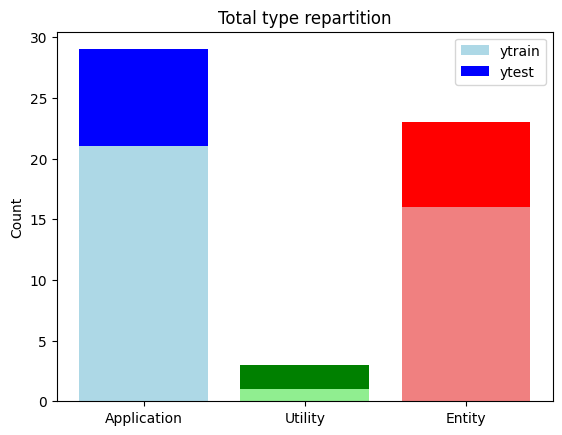

In [15]:
visualize_counts(np.bincount(ytrain), np.bincount(ytest))

## Génération d'histogramme pour la répartition des élèments par classe par modèle de prédiction

In [16]:
def generate_classification_report_for_types(y_true, y_pred, prediction_model_name):
    # Map unique labels to their corresponding names
    label_names_map = {-1: "None", 0: "Application", 1: "Utility", 2: "Entity"}

    # Generate the classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    # Extract support values
    supports = [report[str(key)]['support'] for key in sorted(report.keys())[:-3]]
    labels = [label_names_map[int(key)] for key in sorted(report.keys())[:-3]]

    # Colors for each bar
    colors = ['blue', 'green', 'red']

    # Generate the histogram
    plt.bar(labels, supports, color=colors)
    plt.ylabel('Number of classes')
    plt.title(f'Type repartition using {prediction_model_name}')
    plt.show()

## Decision Tree

0.7647058823529411
[[8 0 0]
 [1 0 1]
 [2 0 5]]
              precision    recall  f1-score   support

 Application       0.73      1.00      0.84         8
     Utility       0.00      0.00      0.00         2
      Entity       0.83      0.71      0.77         7

    accuracy                           0.76        17
   macro avg       0.52      0.57      0.54        17
weighted avg       0.69      0.76      0.71        17



/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: Undefin

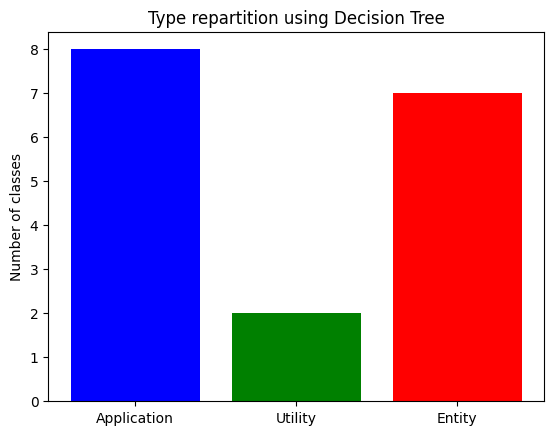

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=2).fit(Xtrain, ytrain)
decision_tree_predictions = decision_tree_classifier.predict(Xtest)
decision_tree_accuracy = accuracy_score(ytest, decision_tree_predictions)
decision_tree_confusion_matrix = confusion_matrix(ytest, decision_tree_predictions)
print(decision_tree_accuracy)
print(decision_tree_confusion_matrix)
generate_classification_report(ytest, decision_tree_predictions)
generate_classification_report_for_types(ytest, decision_tree_predictions, "Decision Tree")
generate_classification_report_to_csv(ytest, decision_tree_predictions, "decision_tree", model_type)

## SVM

SVM Accuracy: 0.7647058823529411
[[7 0 1]
 [1 0 1]
 [1 0 6]]
              precision    recall  f1-score   support

 Application       0.78      0.88      0.82         8
     Utility       0.00      0.00      0.00         2
      Entity       0.75      0.86      0.80         7

    accuracy                           0.76        17
   macro avg       0.51      0.58      0.54        17
weighted avg       0.67      0.76      0.72        17



/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: Undefin

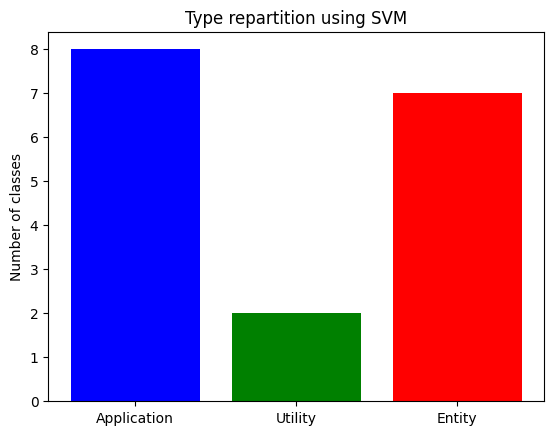

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
svm_classifier = SVC(kernel='linear', C=2, probability=True).fit(Xtrain, ytrain)
svm_predictions = svm_classifier.predict(Xtest)
svm_accuracy = accuracy_score(ytest, svm_predictions)
svm_confusion_matrix = confusion_matrix(ytest, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")
print(svm_confusion_matrix)
generate_classification_report(ytest, svm_predictions)
generate_classification_report_for_types(ytest, svm_predictions, "SVM")
generate_classification_report_to_csv(ytest, svm_predictions, "svm", model_type)

## KNN

0.7647058823529411
[[7 0 1]
 [1 0 1]
 [1 0 6]]
              precision    recall  f1-score   support

 Application       0.78      0.88      0.82         8
     Utility       0.00      0.00      0.00         2
      Entity       0.75      0.86      0.80         7

    accuracy                           0.76        17
   macro avg       0.51      0.58      0.54        17
weighted avg       0.67      0.76      0.72        17



/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: Undefin

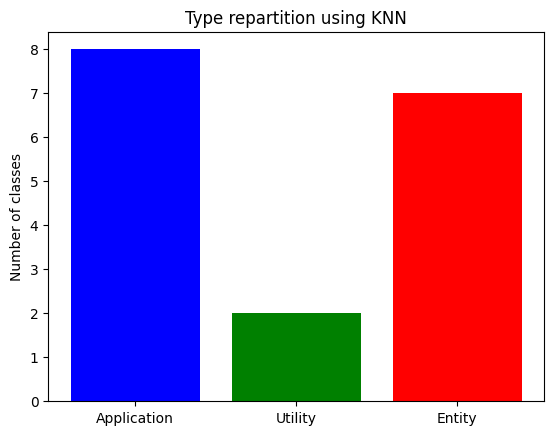

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
knn_classifier = KNeighborsClassifier(n_neighbors=5).fit(Xtrain, ytrain)
knn_predictions = knn_classifier.predict(Xtest)
knn_accuracy = accuracy_score(ytest, knn_predictions)
knn_confusion_matrix = confusion_matrix(ytest, knn_predictions)
print(knn_accuracy)
print(knn_confusion_matrix)
generate_classification_report(ytest, knn_predictions)
generate_classification_report_for_types(ytest, knn_predictions, "KNN")
generate_classification_report_to_csv(ytest, knn_predictions, "knn", model_type)

## LogisticRegression

0.7647058823529411
[[7 0 1]
 [1 0 1]
 [1 0 6]]
              precision    recall  f1-score   support

 Application       0.78      0.88      0.82         8
     Utility       0.00      0.00      0.00         2
      Entity       0.75      0.86      0.80         7

    accuracy                           0.76        17
   macro avg       0.51      0.58      0.54        17
weighted avg       0.67      0.76      0.72        17



/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sam

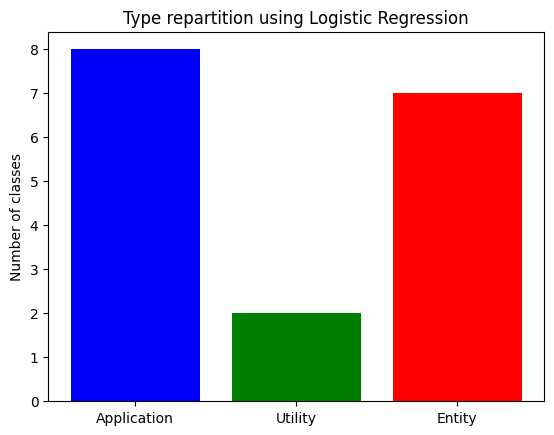

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
logistic_regression_classifier = LogisticRegression(random_state=0).fit(Xtrain, ytrain)
logistic_regression_predictions = logistic_regression_classifier.predict(Xtest)
logistic_regression_accuracy = accuracy_score(ytest, logistic_regression_predictions)
logistic_regression_confusion_matrix = confusion_matrix(ytest, logistic_regression_predictions)
print(logistic_regression_accuracy)
print(logistic_regression_confusion_matrix)
generate_classification_report(ytest, logistic_regression_predictions)
generate_classification_report_for_types(ytest, logistic_regression_predictions, "Logistic Regression")
generate_classification_report_to_csv(ytest, logistic_regression_predictions, "logistic_regression", model_type)

## Gaussian NB

0.7647058823529411
[[7 0 1]
 [1 0 1]
 [1 0 6]]
              precision    recall  f1-score   support

 Application       0.78      0.88      0.82         8
     Utility       0.00      0.00      0.00         2
      Entity       0.75      0.86      0.80         7

    accuracy                           0.76        17
   macro avg       0.51      0.58      0.54        17
weighted avg       0.67      0.76      0.72        17



/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: Undefin

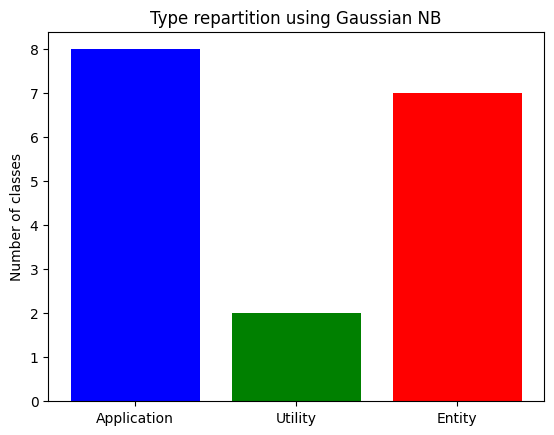

/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
naive_bayes_classifier = GaussianNB().fit(Xtrain, ytrain)
naive_bayes_predictions = naive_bayes_classifier.predict(Xtest)
naive_bayes_accuracy = accuracy_score(ytest, naive_bayes_predictions)
naive_bayes_confusion_matrix = confusion_matrix(ytest, naive_bayes_predictions)
print(naive_bayes_accuracy)
print(naive_bayes_confusion_matrix)
generate_classification_report(ytest, naive_bayes_predictions)
generate_classification_report_for_types(ytest, naive_bayes_predictions, "Gaussian NB")
generate_classification_report_to_csv(ytest, naive_bayes_predictions, "gaussian_nb", model_type)

## Ensemble learning

In [22]:
# Combine individual classifiers into an ensemble
ensemble_clf = VotingClassifier(estimators=[
('svm', svm_classifier), ('knn', knn_classifier), ('dt', decision_tree_classifier), ('log_reg', logistic_regression_classifier), ('gnb', naive_bayes_classifier)],
voting='soft')

# Use SVM as the base estimator for AdaBoost
svm_base = SVC(kernel='linear', C=2, probability=True) # Can use any other classifier as the base estimator
ada_boost = AdaBoostClassifier(base_estimator=svm_base, n_estimators=50, algorithm='SAMME.R', random_state=1)

# Combine the ensemble classifier with AdaBoost
final_ensemble = VotingClassifier(estimators=[
    ('ensemble_clf', ensemble_clf), ('ada_boost', ada_boost)],
    voting='soft')

# Fit model to your data
final_ensemble.fit(Xtrain, ytrain)

# Evaluate model
ensemble_predictions = final_ensemble.predict(Xtest)
ensemble_accuracy = accuracy_score(ytest, ensemble_predictions)
print('Accuracy:', ensemble_accuracy)
ensemble_confusion_matrix = confusion_matrix(ytest, ensemble_predictions)
print(ensemble_confusion_matrix)
print(classification_report(ytest, ensemble_predictions))

/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Python/3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.7647058823529411
[[7 0 1]
 [1 0 1]
 [1 0 6]]
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.00      0.00      0.00         2
           2       0.75      0.86      0.80         7

    accuracy                           0.76        17
   macro avg       0.51      0.58      0.54        17
weighted avg       0.67      0.76      0.72        17



/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Visualisation par modèle d'embedding

In [28]:
def visualize_csv(filename):
    # Read the data directly from the CSV file
    df = pd.read_csv(filename)

    labels = df['label'].unique()
    models = df['model_name'].unique()
    metrics = ['precision', 'recall', 'f1-score']

    barWidth = 0.2
    r = np.arange(len(labels) * len(models))  # the label locations

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(15, 7))

    for i, metric in enumerate(metrics):
        values = [df[(df['label'] == label) & (df['model_name'] == model)][metric].values[0]
                  for model in models for label in labels]
        positions = [j + i * barWidth for j in r]
        ax.bar(positions, values, width=barWidth, label=metric)

    # Format and show the plot
    ax.set_xlabel('Label')
    ax.set_ylabel('Score')
    ax.set_title(f'Metrics by label from embedding model : {filename}')
    ax.set_xticks(r + barWidth)
    ax.set_xticklabels([f'{model}-{label}' for model in models for label in labels], rotation=90)  # Show combinations of model-label
    ax.legend()

    plt.tight_layout()
    plt.show()

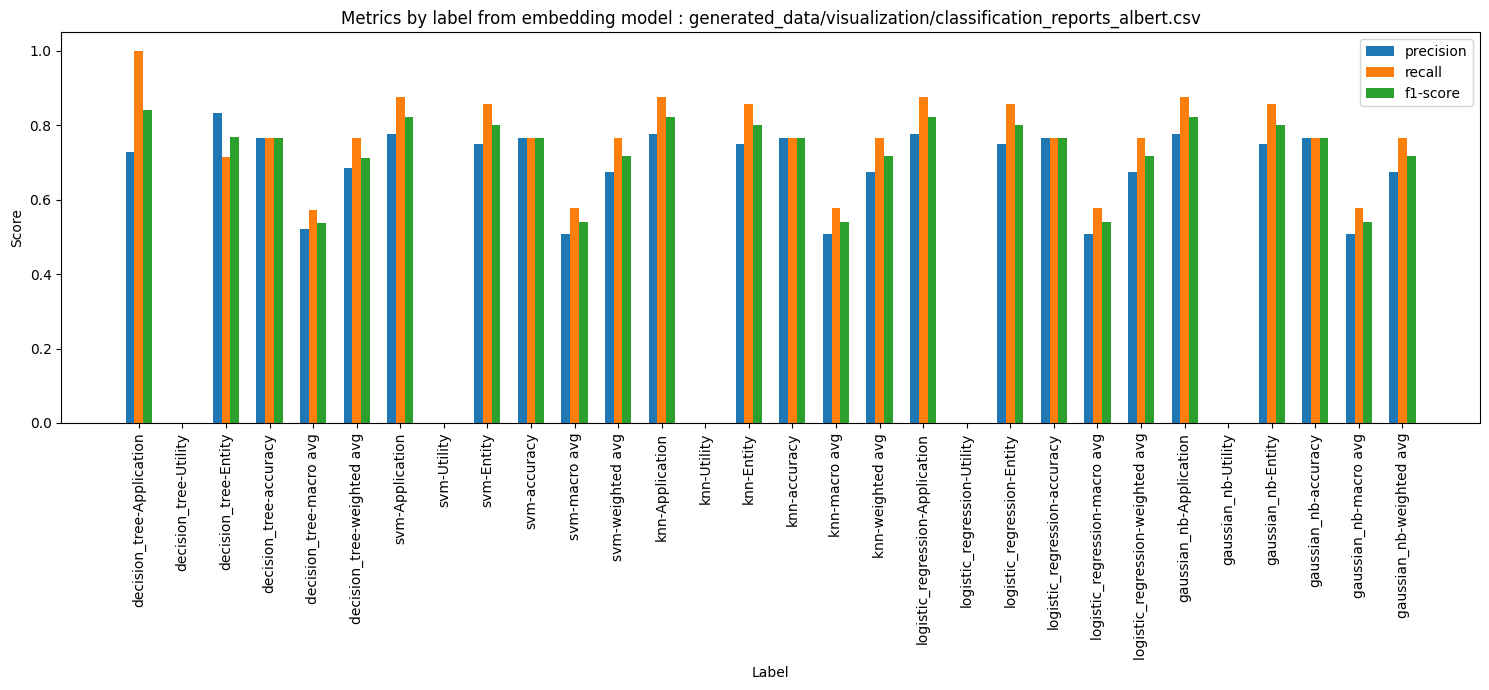

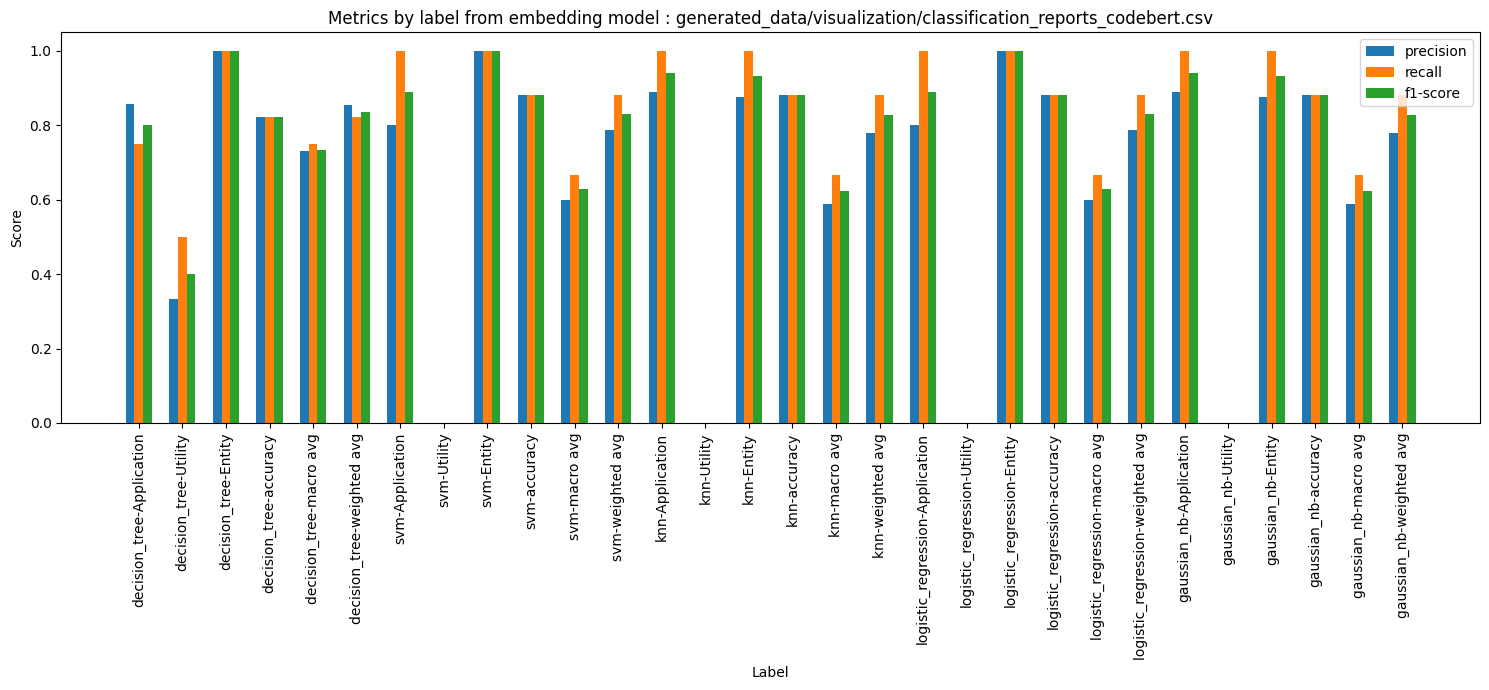

In [29]:
# Path to the directory
directory_path = 'generated_data/visualization/'

# Get all the csv filenames in the directory
filenames = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.csv')]

# Loop through each filename and visualize the data
for filename in filenames:
    visualize_csv(filename)